# Discover clinically relevant, predictive T cell signatures <a class="tocSkip">

Derive T cell signatures from decipher latent information correlating CD8+ T cell expression, and test for significance using T cell expression downsampled to median sample counts

Author: Kevin Hoffer-Hawlik

## Setup

In [ ]:
import warnings
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import scvi
import seaborn as sns
import scipy.stats
import pickle
import seaborn as sns
import decipher as dc

/home/kh3205/anaconda3/envs/decipher/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/kh3205/anaconda3/envs/decipher/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/kh3205/anaconda3/envs/decipher/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter(action='ignore',)

In [3]:
warnings.simplefilter(action='ignore',)

In [ ]:
from statsmodels.stats.multitest import multipletests
import tqdm

def permutation_test(df, labels, label_0='label_0', label_1='label_1', num_permutations=1000):
    # Convert string labels to binary labels (0 and 1)
    labels = labels.map({label_0: 0, label_1: 1})
    print(df.shape)
    
    # Function to calculate the test statistic (difference in means)
    def calculate_statistic(df, labels):
        return df[labels == 1].mean() - df[labels == 0].mean()

    # Calculate the observed test statistic
    observed_stats = calculate_statistic(df, labels).abs()
    permuted_stats = np.zeros((num_permutations, observed_stats.shape[0]))

    # Perform permutation test
    for i in tqdm.tqdm((range(num_permutations))):
        permuted_labels = np.random.permutation(labels)
        permuted_stat = calculate_statistic(df, permuted_labels).abs()
        permuted_stats[i, :] = permuted_stat.values

    # Calculate p-values
    p_values = (np.sum(permuted_stats >= observed_stats.values, axis=0) + 1) / (num_permutations + 1)
    
    return pd.Series(p_values, index=df.columns)

def fdr_correction(p_values, alpha=0.05):
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    return pd.Series(pvals_corrected, index=p_values.index)

In [ ]:
# positive = enriched in label_1, negative = enriched in label_0
def permutation_test_signed(df, labels, label_0='label_0', label_1='label_1', num_permutations=1000):
    # Convert string labels to binary labels (0 and 1)
    labels = labels.map({label_0: 0, label_1: 1})
    
    # Function to calculate the test statistic (difference in means)
    def calculate_statistic(df, labels):
        return df[labels == 1].mean() - df[labels == 0].mean()

    # Calculate the observed test statistic
    observed_stats = calculate_statistic(df, labels)
    permuted_stats = np.zeros((num_permutations, observed_stats.shape[0]))

    # Perform permutation test
    for i in tqdm.tqdm((range(num_permutations))):
        permuted_labels = np.random.permutation(labels)
        permuted_stat = calculate_statistic(df, permuted_labels)
        permuted_stats[i, :] = permuted_stat.values

    # Calculate two-sided p-values
    p_values = np.mean(np.abs(permuted_stats) >= np.abs(observed_stats.values), axis=0)
    
    # Create a DataFrame with test statistics and p-values
    results_df = pd.DataFrame({
        'test_statistic': observed_stats,
        'p_value': p_values
    }, index=df.columns)
    
    return results_df

## Load data and set global settings

In [4]:
clinical_outcomes = pd.read_csv("clin_022625.csv")
clinical_outcomes.set_index(keys = 'sample', inplace=True)

In [5]:
marker_genes_filepath = 'marker_genes_dict_030823.pickle'
with open(marker_genes_filepath, 'rb') as handle:
    tcell_marker_genes = pickle.load(handle)

In [6]:
signatures = ["activation_markers_z_score_scvi_normalized",
              "exhaustion_markers_z_score_scvi_normalized",
              "CD8_T_cell_activation_z_score_scvi_normalized",
              "Type_II_interferon_response_z_score_scvi_normalized",
              "Exhaustion/Terminal_differentiation_z_score_scvi_normalized",
              "CD8_TIL_dysfunction_z_score_scvi_normalized",
              "T_cell_co-inhibitory_receptors_z_score_scvi_normalized",
              "naive_markers_z_score_scvi_normalized",
              "effector_cytokines_z_score_scvi_normalized",
              
              "Terminal_exhaustion_z_score_scvi_normalized", 
              "Precursor_exhaustion_z_score_scvi_normalized", 
              "T_naive_z_score_scvi_normalized", 
              "T_stem_central_memory_z_score_scvi_normalized", 
              "T_central_memory_z_score_scvi_normalized", 
              "T_effector_memory_z_score_scvi_normalized", 
              "T_terminal_effector_z_score_scvi_normalized", 
             ]

full_signatures = [s + '_z_score_scvi_normalized' for s in list(tcell_marker_genes.keys())[1:]]

In [7]:
tcells = sc.read_h5ad('tcells_decipher_041024.h5ad')
tcells.shape

(20512, 8170)

In [8]:
# harmonize clinical data
tcells.obs['time'] = tcells.obs['sample'].replace(clinical_outcomes['time'])
tcells.obs['treated'] = tcells.obs['sample'].replace(clinical_outcomes['treated'])
tcells.obs['responder'] = tcells.obs['sample'].replace(clinical_outcomes['responder'])
tcells.obs['treat_resp'] = tcells.obs['sample'].replace(clinical_outcomes['treat_resp'])

In [9]:
cd8 = tcells[tcells.obs['cell_type_khh'].isin(['Naive CD8+ T','CD8+ T'])]
tcells_copy = tcells.copy()
tcells = cd8

# Initial decipher_v1 visualizations (both CD8 and CD4 T)

In [ ]:
tcells_copy.obs['decipher_v1'] = tcells_copy.obsm['decipher_v'][:,0]

In [9]:
# days_to/from_ICI_start buckets: [<0] [0,23] [24,103] [104,187] [188+]
tcells_copy.obs['bucketed_days_to/from_ICI_start'] = '<0'
tcells_copy.obs.loc[(tcells_copy.obs['days_to/from_ICI_start']>=0) & ((tcells_copy.obs['days_to/from_ICI_start']<=23)),
                'bucketed_days_to/from_ICI_start'] = '0-23'
tcells_copy.obs.loc[(tcells_copy.obs['days_to/from_ICI_start']>=24) & ((tcells_copy.obs['days_to/from_ICI_start']<=103)),
                'bucketed_days_to/from_ICI_start'] = '24-103'
tcells_copy.obs.loc[(tcells_copy.obs['days_to/from_ICI_start']>=104) & ((tcells_copy.obs['days_to/from_ICI_start']<=187)),
                'bucketed_days_to/from_ICI_start'] = '104-187'
tcells_copy.obs.loc[tcells_copy.obs['days_to/from_ICI_start']>=188,'bucketed_days_to/from_ICI_start'] = '188+'
tcells_copy.obs['bucketed_days_to/from_ICI_start'] = tcells_copy.obs['bucketed_days_to/from_ICI_start'].astype("category")
tcells_copy.obs['bucketed_days_to/from_ICI_start'] = tcells_copy.obs['bucketed_days_to/from_ICI_start'].cat.reorder_categories(['<0','0-23','24-103','104-187','188+'])

In [10]:
tcells_copy.obs['treatment_time'] = tcells_copy.obs['sample'].replace(clinical_outcomes['time'])
tcells_copy.obs['treated'] = tcells_copy.obs['sample'].replace(clinical_outcomes['treated'])

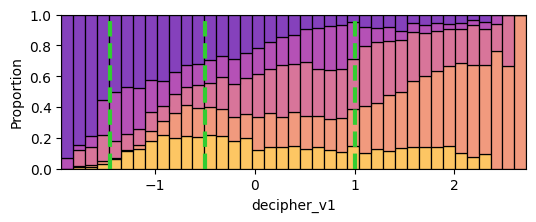

In [11]:
plt.subplots(figsize=(6,2))
sns.histplot(tcells_copy.obs, x='decipher_v1', hue='bucketed_days_to/from_ICI_start', multiple='fill', stat='proportion', palette='plasma', legend=False)
plt.gca().axvline(-1.45, color='limegreen', lw=3.0, ls='--')
plt.gca().axvline(-.5, color='limegreen', lw=3.0, ls='--')
plt.gca().axvline(1.0, color='limegreen', lw=3.0, ls='--')

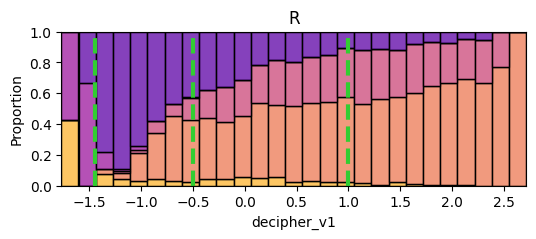

In [12]:
R_df = tcells_copy.obs[tcells_copy.obs['response']=='Responder']
plt.subplots(figsize=(6,2))
sns.histplot(R_df, x='decipher_v1', hue='bucketed_days_to/from_ICI_start', multiple='fill', stat='proportion', palette='plasma', legend=False)
plt.title('R')
plt.gca().axvline(-1.45, color='limegreen', lw=3.0, ls='--')
plt.gca().axvline(-.5, color='limegreen', lw=3.0, ls='--')
plt.gca().axvline(1.0, color='limegreen', lw=3.0, ls='--')

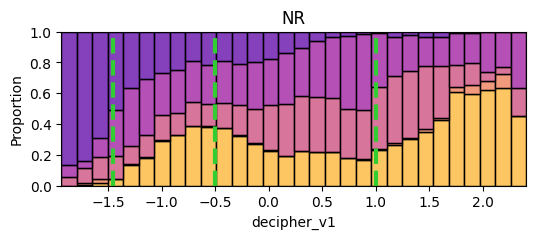

In [13]:
NR_df = tcells_copy.obs[tcells_copy.obs['response']=='Non-responder']
plt.subplots(figsize=(6,2))
sns.histplot(NR_df, x='decipher_v1', hue='bucketed_days_to/from_ICI_start', multiple='fill', stat='proportion', palette='plasma', legend=False)
plt.title('NR')
plt.gca().axvline(-1.45, color='limegreen', lw=3.0, ls='--')
plt.gca().axvline(-.5, color='limegreen', lw=3.0, ls='--')
plt.gca().axvline(1.0, color='limegreen', lw=3.0, ls='--')

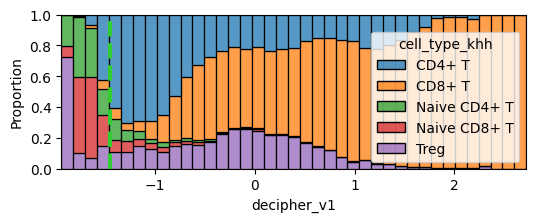

In [14]:
plt.subplots(figsize=(6,2))
sns.histplot(tcells_copy.obs, x='decipher_v1', hue='cell_type_khh', multiple='fill', stat='proportion')
plt.gca().axvline(-1.45, color='limegreen', lw=3.0, ls='--')

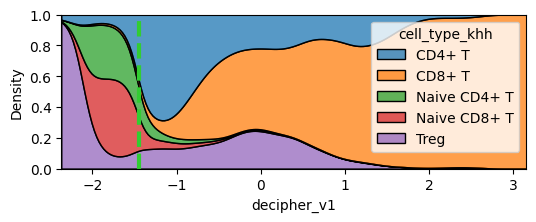

In [15]:
plt.subplots(figsize=(6,2))
sns.kdeplot(tcells_copy.obs, x='decipher_v1', hue='cell_type_khh', multiple='fill')
plt.gca().axvline(-1.45, color='limegreen', lw=3.0, ls='--')

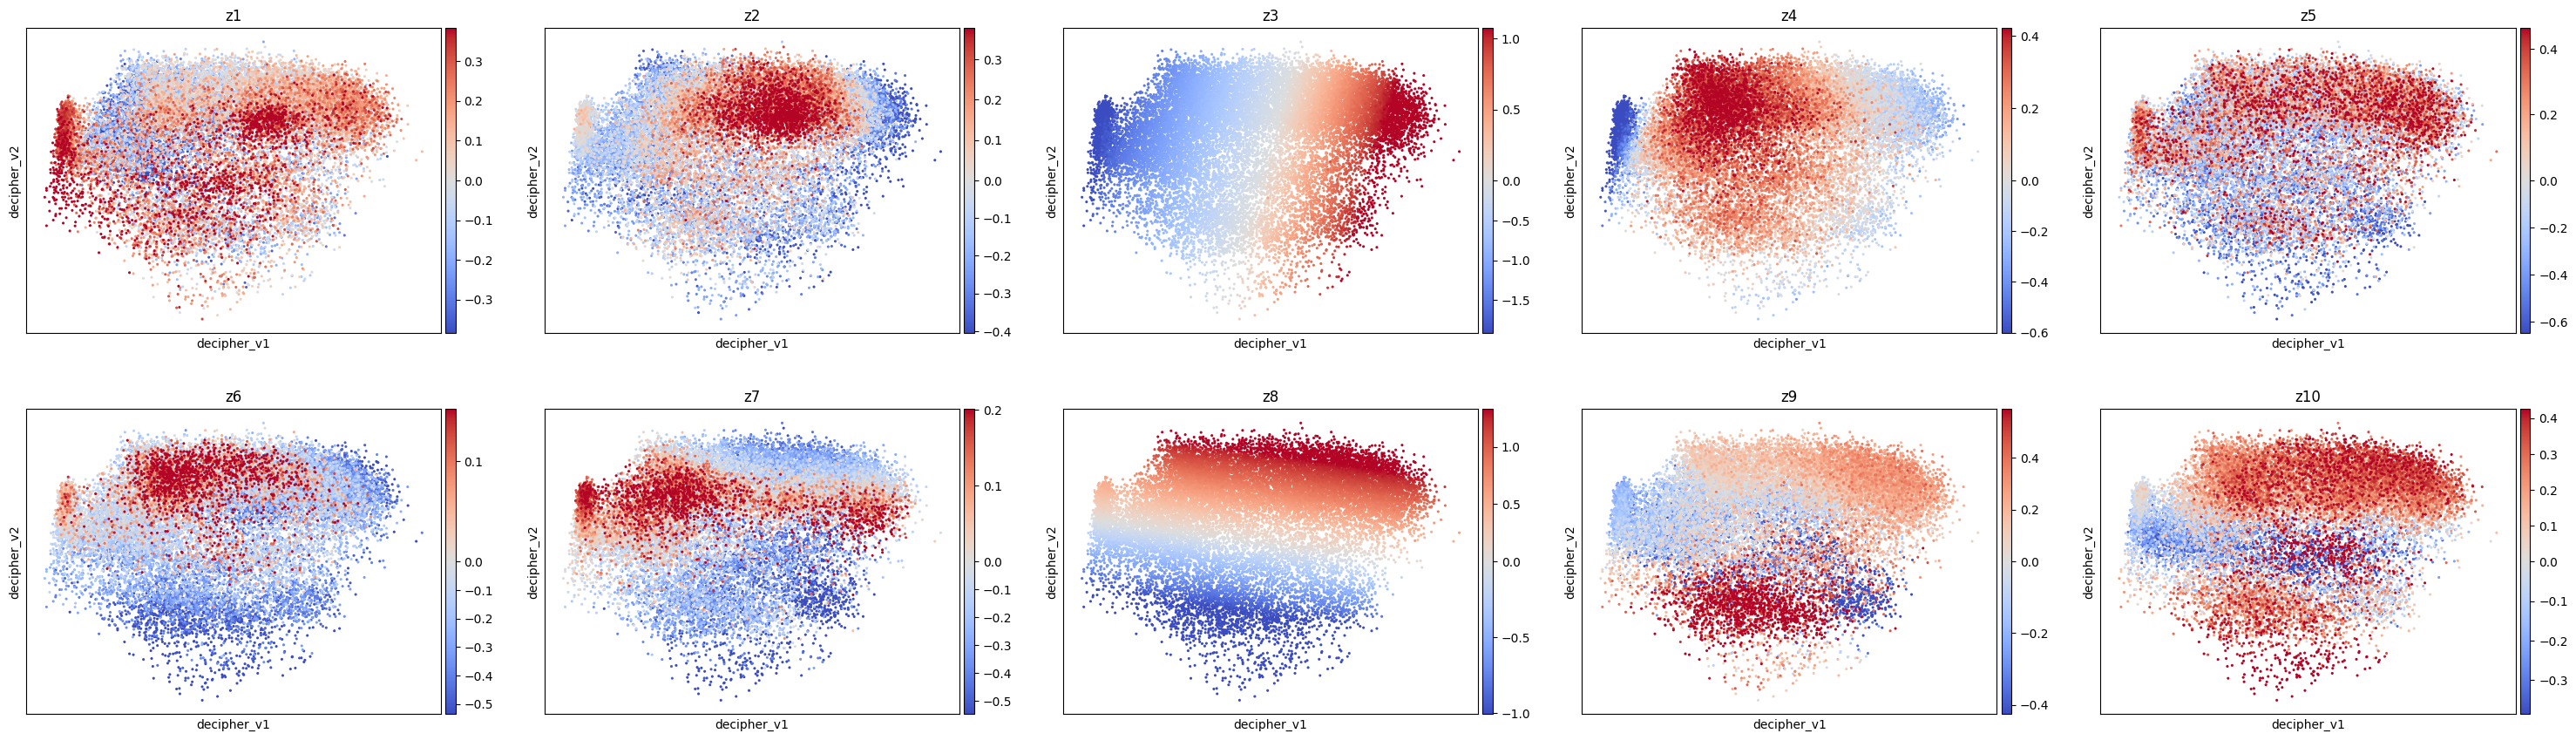

In [19]:
sc.pl.embedding(tcells_copy, basis='decipher_v', color=['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10'], 
                ncols=5, cmap='coolwarm', vmin='p05', vmax='p95', vcenter=0, s=20)

In [ ]:
# defining top 100 and bottom 100 for each factor using both CD8 and CD4 T cells
sigs = {}
X = tcells_copy.to_df(layer='log_counts')
Z = tcells_copy.obs[['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10']].copy()
for z in 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10':
    sig = X.corrwith(Z[z],axis=0)
    sigs[z] = sig
sigs_df_correlations = pd.DataFrame(sigs)
sigs_df_correlations.to_csv('cd8+cd4_predictive_signatures_011525_correlations.csv')

# Derive signatures based on correlative genes and decipher latent space values (CD8+ T only)

Goal: find precursor signature based on duration of ICB (corresponding with V1 axis and trajectories)

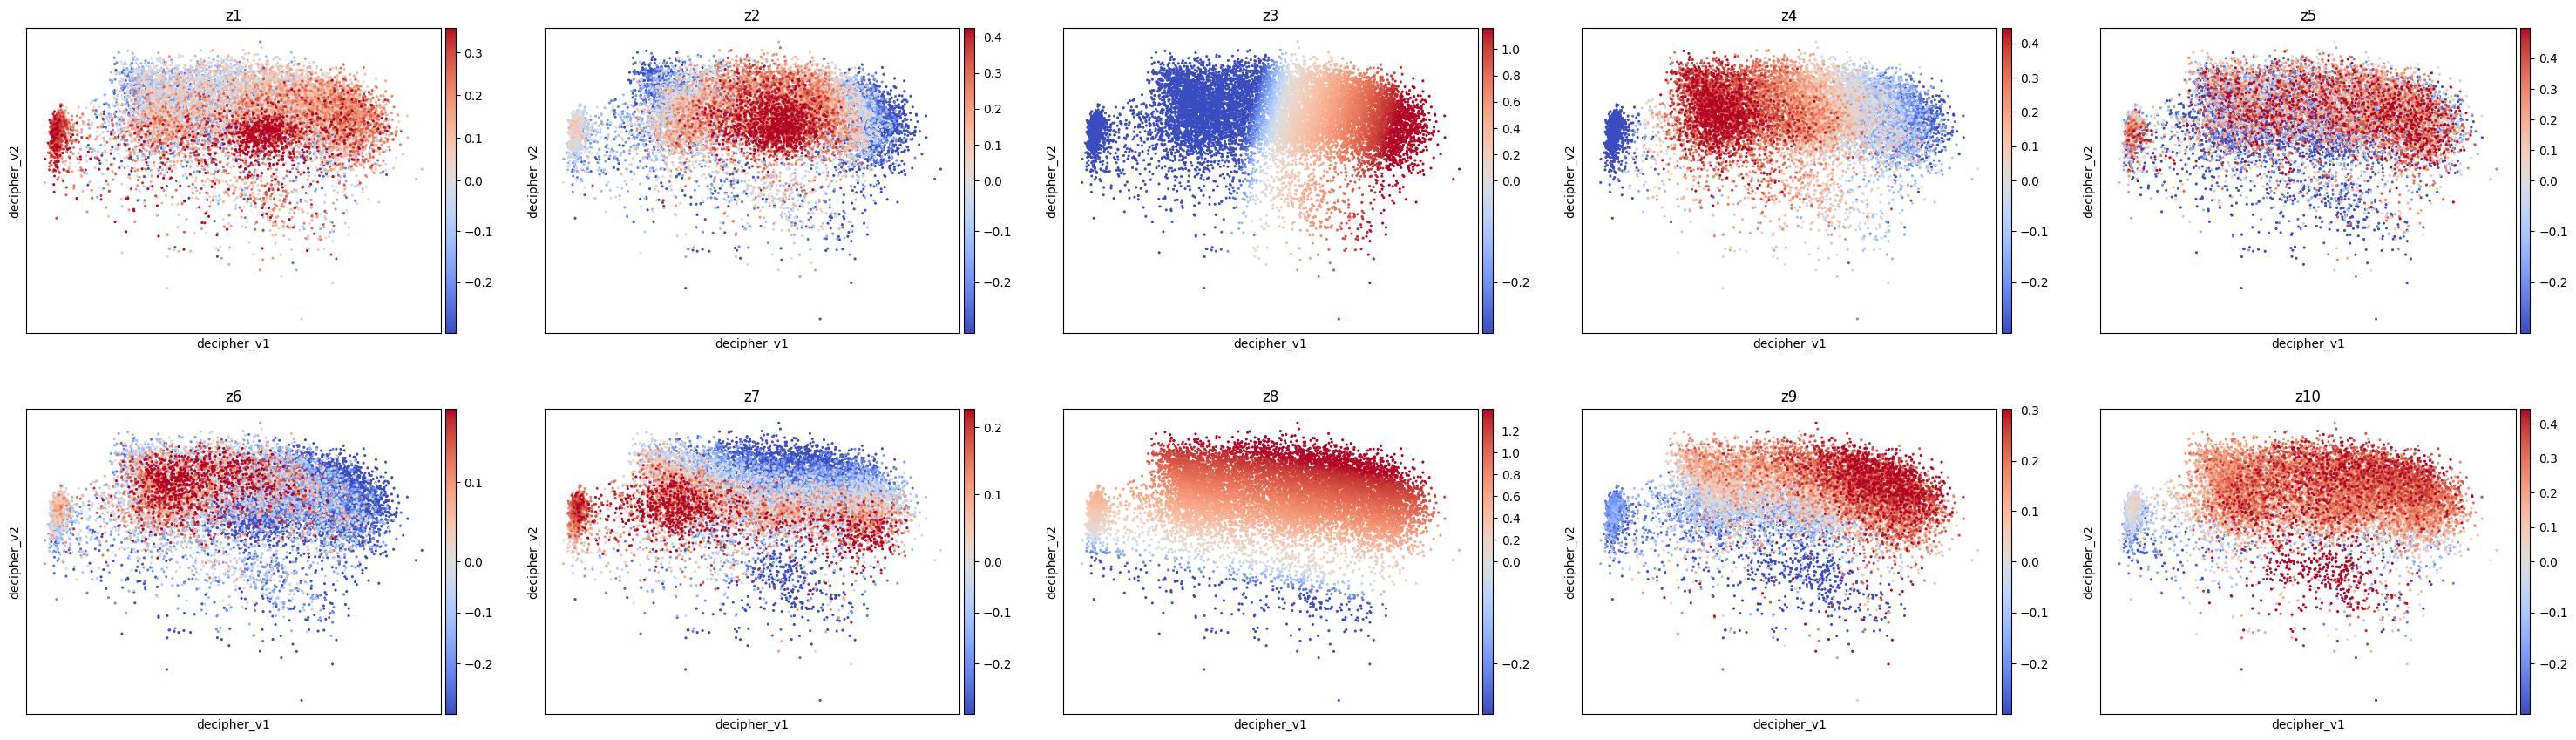

In [19]:
sc.pl.embedding(tcells, basis='decipher_v', color=['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10'], 
                ncols=5, cmap='coolwarm', vmin=-.3, vmax='p95', vcenter=0, s=20)

## Unbiased identification of predictive/interpretable signatures

Three tests: R_pre vs NR_pre, R_pre vs R_post, NR_pre vs NR_post

In [ ]:
# defining top 100 and bottom 100 genes correlating with each Decipher factor
sigs = {}
X = tcells.to_df(layer='log_counts')
Z = tcells.obs[['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10']].copy()
for z in 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10':
    sig = X.corrwith(Z[z],axis=0)
    sig = sig.sort_values(ascending=False)
    sigs[z+'_up'] = sig[:100].index
    sig = sig.sort_values(ascending=True)
    sigs[z+'_dn'] = sig[:100].index
sigs_df = pd.DataFrame(sigs)

In [11]:
sigs_df

z1_up    z1_dn    z2_up     z2_dn    z3_up      z3_dn       z4_up  \
0    IL6ST    AHNAK    FKBP5      CCL4     LYST       LEF1        AOAH   
1    GFOD1    SAMD3     AOAH    CCL4L2      TOX  LINC00861       AHNAK   
2      TTN    ITGB1    ITGA1      ZEB2      PAM     RIPOR2       SAMD3   
3   IPCEF1     GNLY    DAPK2      SNX9     CBLB       TCF7        TC2N   
4      TXK    ANXA1  PPP2R2B    RNF19A     DGKH       IL7R        GZMK   
..     ...      ...      ...       ...      ...        ...         ...   
95  ZNF831   ADGRG5     CSF1    ANTXR2  GPR137B     CDC14A        GBP5   
96   FOXO1     HIP1    DDIT4     TAGAP  PIP5K1B      SAMD3  AC068587.4   
97    DAB1  ALOX5AP    CLIC5     CTLA4   SLC7A5    RALGPS2        CCR4   
98    CCL4    TPD52     CCR9    LRRC8B   GLCCI1      TANC2       PDE4B   
99     LBH     CCL5     TET1  TNFRSF1B    ZBED2       EML4        IL32   

         z4_dn    z5_up       z5_dn      z6_up    z6_dn       z7_up   z7_dn  \
0        BACH2     ACTB       PARP8       AOAH     DGKH       NR3C2    GBP5   
1         LEF1      B2M     PPP2R5C  LINC00861  ZC3H12C       BACH2    CD38   
2        PRKCA    HLA-A       FOXP1     RIPOR2    PRKCA        LEF1  HAVCR2   
3      TRABD2A    HLA-B     PITPNC1      SAMD3      TOX        TCF7    CCL5   
4         CCR7   EEF1A1        ANK3      CAMK4      PAM  FP671120.4   DAPK2   
..         ...      ...         ...        ...      ...         ...     ...   
95        CD55    PGAM1  AC068587.4      S1PR1    MAST4      EXOC6B    BCL3   
96     DENND5A    MZT2B      MAP3K5       DGKD      CD7         LTB  ARID5B   
97      SPTBN1   EIF4A1     DENND4A    TMEM63A     PON2     A2M-AS1  IQGAP2   
98  AL138720.1   PABPC1      PIK3R5      APBA2    VCAM1        HHAT    GALM   
99       PSMA1  SLC25A3      RAD51B   TMEM131L     TNS3    HSP90AB1   DLEU2   

      z8_up    z8_dn      z9_up       z9_dn     z10_up      z10_dn  
0      CCL5     LEF1        B2M       FKBP5       AOAH        LEF1  
1      NKG7    FOXP1       NKG7       FOXP1       CCL5       BACH2  
2       B2M     XIST      HLA-A        XIST       PRF1        CCR7  
3      CD8A    BACH2     ENTPD1     PITPNC1       NKG7  FP671120.4  
4      PRF1     CCR7       CCL5      CRYBG1       CBLB        TCF7  
..      ...      ...        ...         ...        ...         ...  
95    VCAM1  DENND5A       HCST  AC016831.7      PARP8   LINC01891  
96    TRBV2    PELI2   HLA-DPA1       PLCL1     SFMBT2       ABCA1  
97     IFNG    FOXO1    ZFP36L1  AC245297.3     MAP3K5      CACHD1  
98  AFAP1L2  PPP2R5C  MTRNR2L12        SELL   HLA-DRB1       FKBP5  
99    PDCD1    GCNT4  LINC02416     TNFAIP8  GABARAPL1       DRAIC  

[100 rows x 20 columns]

In [30]:
sigs_df.to_csv('cd8_predictive_signatures_011525.csv')

In [28]:
# export actual correlation values
for z in 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10':
    sig = X.corrwith(Z[z],axis=0)
    sigs[z] = sig
sigs_df_correlations = pd.DataFrame(sigs)

sigs_df_correlations.to_csv('cd8_predictive_signatures_011525_correlations.csv')

In [12]:
tcells.X = tcells.layers['log_counts'].copy()

## Locate significant signatures: 1st attempt (pseudobulked by sample)

Pseudobulk by sample, and perform MWU test (cannot assume normality). Issue arises as CD8+ T cells from samples constitute the whole spectrum of cell states, so pseudobulk mixing would obscure pseudotemporally-resolved signal

In [ ]:
pseudobulk_sigs = pd.DataFrame(
    index = tcells.obs['sample'].unique(),
    columns = sigs_df.columns,
)

for sample in tcells.obs['sample'].unique():
    for sig in sigs_df.columns:
        X = tcells[tcells.obs['sample']==sample, sigs_df[sig]].X
        X = np.divide(np.sum(X), X.size)
        pseudobulk_sigs.loc[sample, sig] = X

In [14]:
pseudobulk_sigs['responder'] = clinical_outcomes['responder']
pseudobulk_sigs['treated'] = clinical_outcomes['treated']

In [15]:
from scipy.stats import mannwhitneyu

In [16]:
# first test R pre vs NR pre for each signature
for sig in pseudobulk_sigs.columns[:-2]:
    x = pseudobulk_sigs.loc[(pseudobulk_sigs['responder'] == 'Responder') & (pseudobulk_sigs['treated'] == 'Untreated'),sig].astype('float64')
    y = pseudobulk_sigs.loc[(pseudobulk_sigs['responder'] == 'Non-responder') & (pseudobulk_sigs['treated'] == 'Untreated'),sig].astype('float64')
    res = mannwhitneyu(x,y)
    if res.pvalue<0.10:
        print(sig, res.pvalue, res.statistic)

z1_dn 0.031746031746031744 19.0
z2_up 0.06349206349206349 18.0
z3_dn 0.031746031746031744 19.0
z4_up 0.06349206349206349 18.0
z6_up 0.015873015873015872 20.0
z8_up 0.06349206349206349 18.0
z10_up 0.06349206349206349 18.0


In [17]:
# second test R post vs R pre
for sig in pseudobulk_sigs.columns[:-2]:
    x = pseudobulk_sigs.loc[(pseudobulk_sigs['responder'] == 'Responder') & (pseudobulk_sigs['treated'] == 'Untreated'),sig].astype('float64')
    y = pseudobulk_sigs.loc[(pseudobulk_sigs['responder'] == 'Responder') & (pseudobulk_sigs['treated'] == 'Treated'),sig].astype('float64')
    res = mannwhitneyu(x,y)
    if res.pvalue<0.10:
        print(sig, res.pvalue, res.statistic)

z1_up 0.07323232323232323 29.0
z1_dn 0.04797979797979798 30.0
z2_up 0.030303030303030304 31.0
z2_dn 0.07323232323232323 29.0
z3_up 0.07323232323232323 29.0
z3_dn 0.01767676767676768 32.0
z4_up 0.030303030303030304 31.0
z5_up 0.07323232323232323 29.0
z5_dn 0.030303030303030304 31.0
z6_up 0.01767676767676768 32.0
z6_dn 0.04797979797979798 30.0
z7_up 0.07323232323232323 29.0
z7_dn 0.07323232323232323 29.0
z8_up 0.07323232323232323 29.0
z8_dn 0.07323232323232323 29.0
z9_dn 0.030303030303030304 31.0
z10_up 0.030303030303030304 31.0


In [18]:
# third test NR post vs NR pre
for sig in pseudobulk_sigs.columns[:-2]:
    x = pseudobulk_sigs.loc[(pseudobulk_sigs['responder'] == 'Non-responder') & (pseudobulk_sigs['treated'] == 'Untreated'),sig].astype('float64')
    y = pseudobulk_sigs.loc[(pseudobulk_sigs['responder'] == 'Non-responder') & (pseudobulk_sigs['treated'] == 'Treated'),sig].astype('float64')
    res = mannwhitneyu(x,y)
    if res.pvalue<0.10:
        print(sig, res.pvalue, res.statistic)

<Axes: xlabel='R_Tx', ylabel='z4_up'>

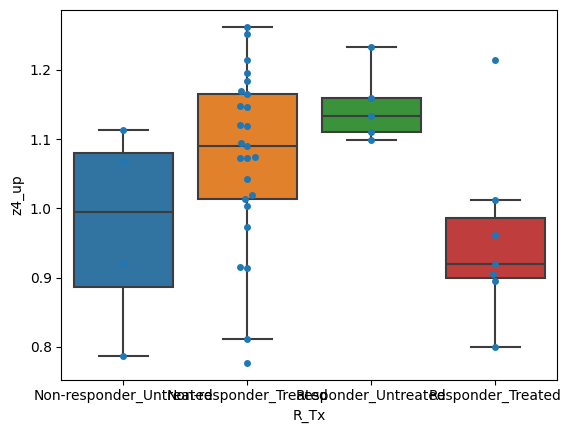

In [19]:
sig = 'z4_up'
df = pseudobulk_sigs[[sig,'responder','treated']]
df['R_Tx'] = df['responder'] + '_' + df['treated']
order = ['Non-responder_Untreated','Non-responder_Treated',
         'Responder_Untreated','Responder_Treated']
sns.boxplot(df, x='R_Tx', y=sig, order=order, fliersize=0, width=.8)
sns.swarmplot(df, x='R_Tx', y=sig, order=order)

### re-perform using permutation tests instead of MWU

In [22]:
# first test R pre vs NR pre for each signature
df = pseudobulk_sigs[pseudobulk_sigs['treated']=='Untreated']
labels = df['responder']
df = df.iloc[:,:-2]
res_1 = permutation_test_signed(df, labels, label_0='Non-responder', label_1='Responder',num_permutations=10000)

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1162.96it/s]


In [23]:
res_1[res_1['p_value']<0.10]

test_statistic  p_value
z1_dn        0.171178   0.0146
z2_up         0.16453   0.0242
z2_dn        0.145462   0.0797
z3_dn        0.136547   0.0146
z4_up        0.174607   0.0242
z5_up        0.184103   0.0912
z5_dn        0.130085   0.0872
z6_up        0.148019   0.0063
z6_dn        0.161704   0.0968
z7_dn        0.143829   0.0724
z8_up        0.143566   0.0720
z10_up       0.193658   0.0401

In [24]:
# second test R post vs R pre
df = pseudobulk_sigs[pseudobulk_sigs['responder']=='Responder']
labels = df['treated']
df = df.iloc[:,:-2]
res_2 = permutation_test_signed(df, labels, label_0='Untreated', label_1='Treated',num_permutations=10000)

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.86it/s]


In [25]:
res_2[res_2['p_value']<0.10]

test_statistic  p_value
z1_up       -0.148568   0.0732
z1_dn       -0.168512   0.0589
z2_up       -0.193448   0.0148
z2_dn       -0.155789   0.0556
z3_up       -0.180543   0.0520
z3_dn       -0.198095   0.0131
z4_up       -0.188846   0.0178
z4_dn       -0.133197   0.0700
z5_up       -0.216836   0.0832
z5_dn       -0.177166   0.0235
z6_up       -0.190137   0.0121
z6_dn       -0.175812   0.0421
z7_dn       -0.132918   0.0567
z8_up       -0.158895   0.0725
z8_dn       -0.170061   0.0547
z9_up       -0.169764   0.0927
z9_dn       -0.182302   0.0363
z10_up      -0.182803   0.0320
z10_dn      -0.151025   0.0825

In [26]:
# third test NR post vs NR pre
df = pseudobulk_sigs[pseudobulk_sigs['responder']=='Non-responder']
labels = df['treated']
df = df.iloc[:,:-2]
res_3 = permutation_test_signed(df, labels, label_0='Untreated', label_1='Treated',num_permutations=10000)

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1113.06it/s]


In [27]:
res_3[res_3['p_value']<0.10]

test_statistic  p_value
z10_up       0.132372   0.0877

In [42]:
# pseudobulk_sigs = pd.read_csv('pseudobulked_z_sigs_011525.csv')

<Axes: xlabel='R_Tx', ylabel='z4_dn'>

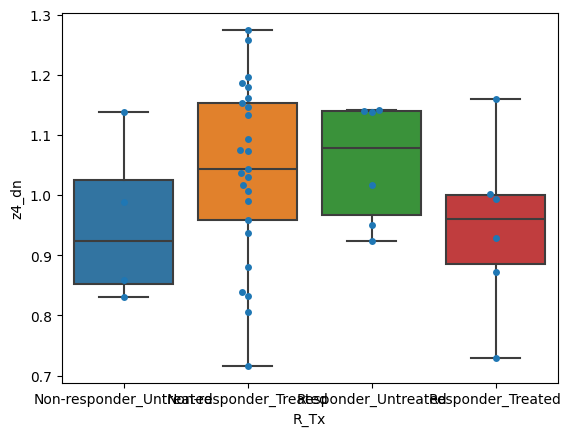

In [44]:
# R pre vs NR pre: z1_dn, z4_up, z5_up, z6_up, z8_up, z10_up
# R post vs R pre: z1_dn, z2_up, z3_dn, z4_up, z5_up, z5_dn, z6_up, z9_up, z10_up
# NR post vs NR pre: z10_up
sig = 'z4_dn'
df = pseudobulk_sigs[[sig,'responder','treated']]
df['R_Tx'] = df['responder'] + '_' + df['treated']
order = ['Non-responder_Untreated','Non-responder_Treated',
         'Responder_Untreated','Responder_Treated']
sns.boxplot(df, x='R_Tx', y=sig, order=order, fliersize=0, width=.8)
sns.swarmplot(df, x='R_Tx', y=sig, order=order)

In [291]:
pseudobulk_sigs.to_csv('pseudobulked_z_sigs_011525.csv')

### heatmap to summarize

In [263]:
# R pre vs NR pre: z1_dn, z4_up, z5_up, z6_up, z8_up, z10_up
# R post vs R pre: z1_dn, z2_up, z3_dn, z4_up, z5_up, z5_dn, z6_up, z9_up, z10_up
# NR post vs NR pre: z10_up
dfs = {'R_pre_v_NR_pre': res_1, 'R_post_v_R_pre': res_2, 'NR_post_v_NR_pre': res_3}
renamed_dfs = []
for name, df in dfs.items():
    renamed_dfs.append(df.rename(columns=lambda col: f"{name}_{col}"))
df = pd.concat(renamed_dfs, axis=1)
df

R_pre_v_NR_pre_test_statistic  R_pre_v_NR_pre_p_value  \
z1_up                       0.095221                  0.2732   
z1_dn                       0.157121                  0.0143   
z2_up                       0.131764                  0.1033   
z2_dn                       0.115086                  0.1702   
z3_up                       0.145426                  0.1880   
z3_dn                       0.098327                  0.1675   
z4_up                       0.143718                  0.0841   
z4_dn                       0.097837                  0.2058   
z5_up                       0.169388                  0.0920   
z5_dn                         0.0948                  0.2096   
z6_up                       0.112716                  0.0928   
z6_dn                       0.123155                  0.1993   
z7_up                       0.063857                  0.3705   
z7_dn                       0.121206                  0.1434   
z8_up                       0.124731                  0.0913   
z8_dn                       0.075587                  0.3279   
z9_up                        0.12267                  0.1443   
z9_dn                       0.098444                  0.2398   
z10_up                      0.161115                  0.0997   
z10_dn                      0.064657                  0.4079   

       R_post_v_R_pre_test_statistic  R_post_v_R_pre_p_value  \
z1_up                      -0.098173                  0.2529   
z1_dn                      -0.168483                  0.0529   
z2_up                      -0.160158                  0.0452   
z2_dn                      -0.121002                  0.1436   
z3_up                      -0.137286                  0.1526   
z3_dn                      -0.154672                  0.0604   
z4_up                      -0.158542                  0.0518   
z4_dn                      -0.104434                  0.1834   
z5_up                      -0.223545                  0.0631   
z5_dn                      -0.136122                  0.0899   
z6_up                      -0.151222                  0.0503   
z6_dn                      -0.128017                  0.1575   
z7_up                      -0.108329                  0.2440   
z7_dn                      -0.109823                  0.1092   
z8_up                      -0.147708                  0.1052   
z8_dn                      -0.131875                  0.1416   
z9_up                      -0.166507                  0.0968   
z9_dn                      -0.144383                  0.1047   
z10_up                     -0.148183                  0.0878   
z10_dn                     -0.099431                  0.2583   

       NR_post_v_NR_pre_test_statistic  NR_post_v_NR_pre_p_value  
z1_up                         0.109383                    0.1084  
z1_dn                         0.091951                    0.2992  
z2_up                         0.108985                    0.1320  
z2_dn                         0.089579                    0.2957  
z3_up                         0.148681                    0.1072  
z3_dn                         0.052798                    0.4296  
z4_up                         0.101792                    0.1547  
z4_dn                          0.08686                    0.2807  
z5_up                         0.071745                    0.5395  
z5_dn                         0.078562                    0.1725  
z6_up                         0.066213                    0.3446  
z6_dn                         0.120758                    0.1432  
z7_up                          0.04016                    0.5889  
z7_dn                         0.110958                    0.1691  
z8_up                         0.102675                    0.2603  
z8_dn                          0.05984                    0.3468  
z9_up                         0.088745                    0.3521  
z9_dn                          0.07318                    0.2484  
z10_up                        0.132372      

In [266]:
# df.to_csv('tcell_sig_permutation_test_results_011525.csv')

In [281]:
df_heatmap = pd.DataFrame(index=df.index, columns = ['R_pre_v_NR_pre', 'R_post_v_R_pre', 'NR_post_v_NR_pre'])
df_heatmap['R_pre_v_NR_pre'] = (df['R_pre_v_NR_pre_p_value'] < 0.10 ).astype('float64')
df_heatmap['R_pre_v_NR_pre'] = df_heatmap['R_pre_v_NR_pre'] * df['R_pre_v_NR_pre_test_statistic'] * -np.log10(df['R_pre_v_NR_pre_p_value'])
df_heatmap['R_post_v_R_pre'] = (df['R_post_v_R_pre_p_value'] < 0.10 ).astype('float64')
df_heatmap['R_post_v_R_pre'] = df_heatmap['R_post_v_R_pre'] * df['R_post_v_R_pre_test_statistic'] * -np.log10(df['R_post_v_R_pre_p_value'])
df_heatmap['NR_post_v_NR_pre'] = (df['NR_post_v_NR_pre_p_value'] < 0.10 ).astype('float64')
df_heatmap['NR_post_v_NR_pre'] = df_heatmap['NR_post_v_NR_pre'] * df['NR_post_v_NR_pre_test_statistic'] * -np.log10(df['NR_post_v_NR_pre_p_value'])
df_heatmap = df_heatmap.astype('float64').T

<Axes: >

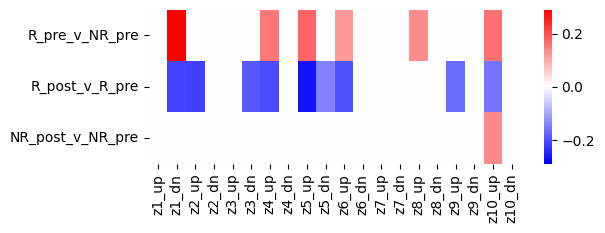

In [289]:
plt.figure(figsize=(6,2))
limit = max(np.max(df_heatmap), -np.min(df_heatmap))
sns.heatmap(df_heatmap, cmap='bwr', vmin=-limit, vmax=limit)

## Locate significant signatures: 2nd attempt (subsample to median counts per sample)

Subsample to median counts per sample so results aren't biased by sample-specific CD8+ T populations. Accounts for intra-sample heterogeneity (spectrum of states) and inter-sample numbers of T cells. Use signed permutation test to avoid assuming normality for statistical testing. 

In [29]:
sigs_df = pd.read_csv('cd8_predictive_signatures_011525.csv', index_col=0)

In [30]:
tcells.X = tcells.layers['log_counts'].copy()

In [31]:
print('median across samples:', tcells.obs.value_counts('sample').median())
tcells.obs.value_counts('sample')

median across samples: 66.0


sample
R310_on2          3591
R310_on1          1742
R294_on            859
R308_pre           857
F25_post           717
F01_pre            702
F22_post           518
F12_pre            432
F26_post           362
F30_post           273
R319_pre           249
F20_post1_pre2     243
F10_post           169
F12_post           157
F07_post1_pre2     152
F29_post1_pre2     112
R319_on            111
R204_pre           100
F17_post            88
F05_pre             79
F15_pre             66
F01_on              57
R329_on             53
F03_post1_on2       52
F16_pre             44
R334_pre            40
F09_post            38
R310_pre            35
R354_pre            34
F04_pre             18
F27_post1_pre2      16
F28_post1_pre2      15
F02_pre             13
R328_on             13
F08_post            11
F23_post             8
F03_post1_pre2       7
F31_post             7
F16_post1_pre2       6
F02_on               5
F18_post             3
Name: count, dtype: int64

In [32]:
target_cells = tcells.obs.value_counts('sample').median().astype('int')

samples = [tcells[tcells.obs['sample'].isin([sample])] for sample in tcells.obs['sample'].cat.categories]

for dat in samples:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

tcells_downsampled = samples[0].concatenate(*samples[1:])

In [33]:
print('median across samples:', tcells_downsampled.obs.value_counts('sample').median())
tcells_downsampled.obs.value_counts('sample')

median across samples: 66.0


sample
F01_pre           66
F05_pre           66
F07_post1_pre2    66
F22_post          66
F25_post          66
F12_pre           66
F15_pre           66
F10_post          66
F12_post          66
R319_pre          66
R310_on2          66
R310_on1          66
R308_pre          66
R204_pre          66
R294_on           66
F20_post1_pre2    66
F17_post          66
F26_post          66
R319_on           66
F30_post          66
F29_post1_pre2    66
F01_on            57
R329_on           53
F03_post1_on2     52
F16_pre           44
R334_pre          40
F09_post          38
R310_pre          35
R354_pre          34
F04_pre           18
F27_post1_pre2    16
F28_post1_pre2    15
F02_pre           13
R328_on           13
F08_post          11
F23_post           8
F03_post1_pre2     7
F31_post           7
F16_post1_pre2     6
F02_on             5
F18_post           3
Name: count, dtype: int64

In [34]:
for sig in sigs_df.columns:
    tcells_downsampled.obs[sig] = tcells_downsampled[:,sigs_df[sig]].X.sum(axis=1)

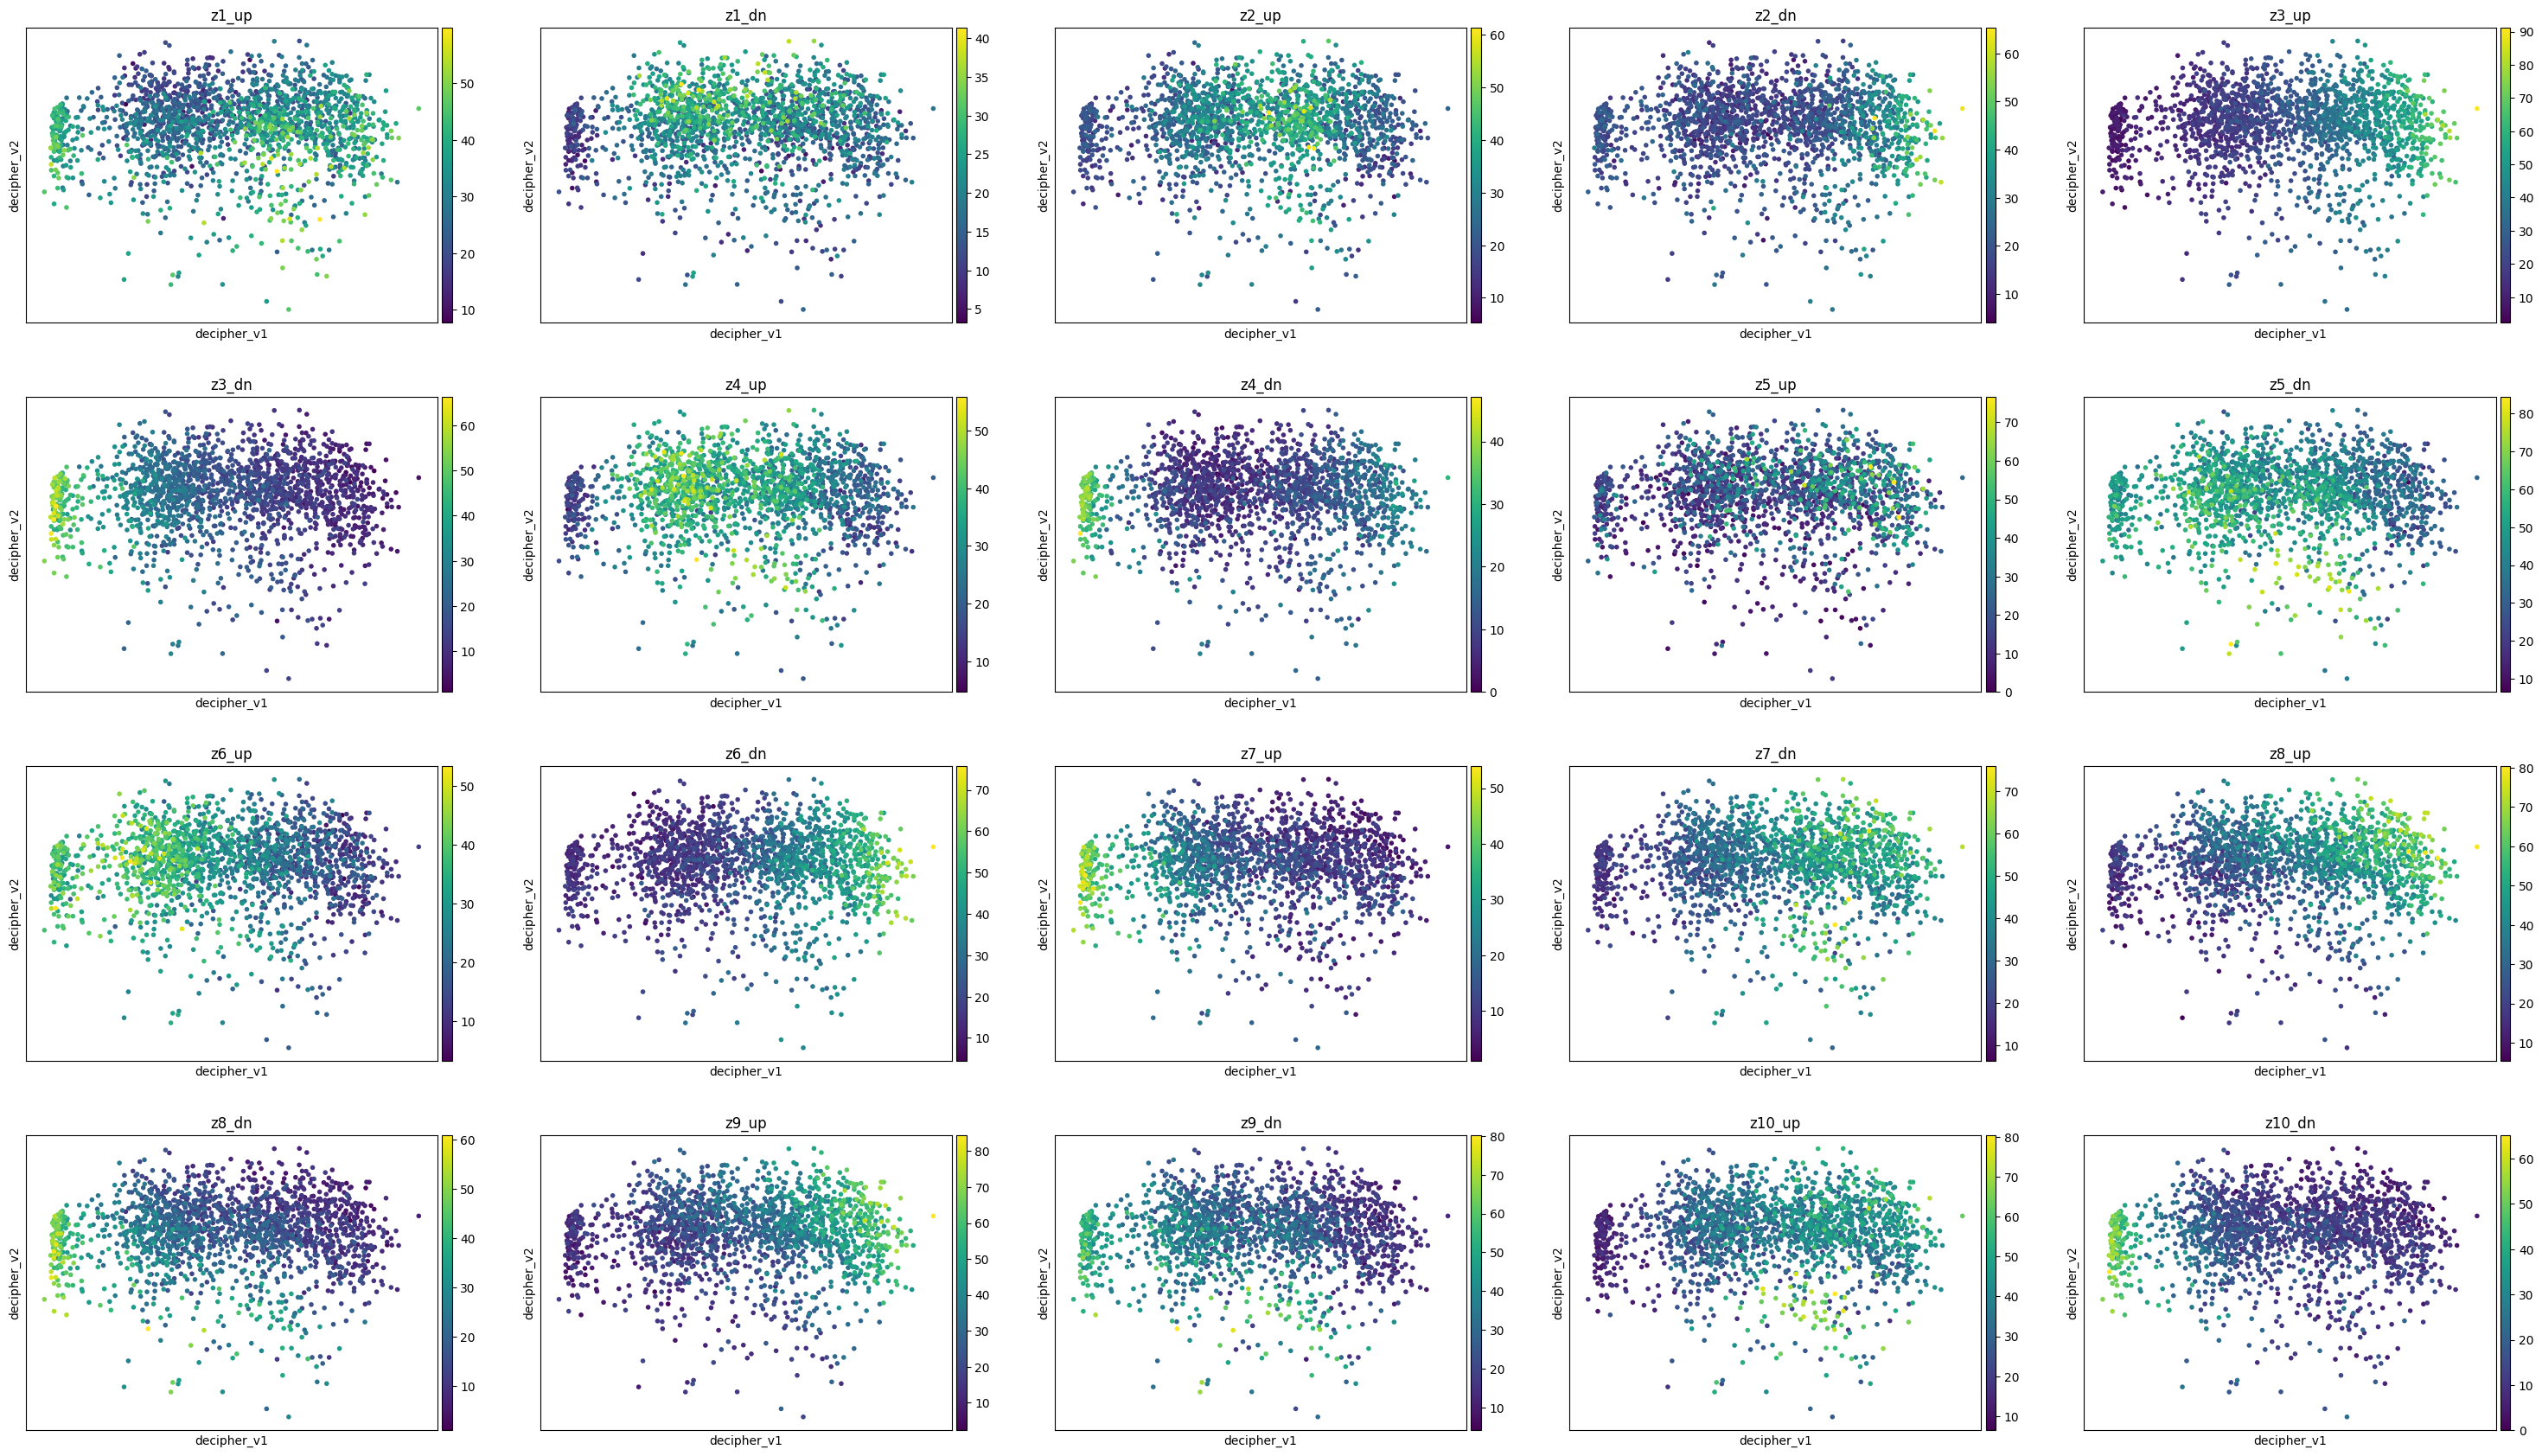

In [35]:
sc.pl.embedding(tcells_downsampled, basis='decipher_v', color=['z1_up', 'z1_dn', 'z2_up', 'z2_dn', 'z3_up', 'z3_dn', 'z4_up', 'z4_dn', 'z5_up', 'z5_dn', 'z6_up', 'z6_dn', 'z7_up', 'z7_dn', 'z8_up', 'z8_dn', 'z9_up', 'z9_dn', 'z10_up', 'z10_dn'], ncols=5)

In [36]:
tcells_downsampled.obs['responder'] = tcells_downsampled.obs['sample'].replace(clinical_outcomes['responder'])
tcells_downsampled.obs['treated'] = tcells_downsampled.obs['sample'].replace(clinical_outcomes['treated'])
df = tcells_downsampled.obs.copy()

df.value_counts(['responder','treated'])

responder      treated  
Non-responder  Treated      1193
Responder      Treated       228
               Untreated     224
Non-responder  Untreated     216
Name: count, dtype: int64

In [37]:
from scipy.stats import mannwhitneyu

In [38]:
# first test R pre vs NR pre for each signature
for sig in sigs_df.columns:
    x = df.loc[(df['responder'] == 'Responder') & (df['treated'] == 'Untreated'),sig].astype('float64')
    y = df.loc[(df['responder'] == 'Non-responder') & (df['treated'] == 'Untreated'),sig].astype('float64')
    res_1 = mannwhitneyu(x,y)
    if res_1.pvalue<0.10:
        print(sig, res_1.pvalue, res_1.statistic)

z1_up 1.6364630734885732e-05 18445.0
z1_dn 7.682636820010918e-13 33749.0
z2_dn 0.004527527733290035 27978.0
z3_up 2.3427108559710884e-09 32156.0
z3_dn 4.239351087152968e-09 16358.0
z4_up 7.982705054838699e-13 33742.0
z4_dn 1.0303195894204896e-05 18310.0
z5_up 0.09661932418100569 21976.0
z5_dn 0.013657672322428049 27481.0
z6_dn 5.673686047240151e-06 30244.0
z7_up 1.1147219924937047e-09 16068.0
z7_dn 5.61794164734627e-13 33806.0
z8_up 1.0964543809607812e-11 33251.0
z8_dn 4.2808538893480125e-07 17449.5
z9_up 4.536914883284469e-09 32011.0
z9_dn 0.0016364586148159392 19992.0
z10_up 6.181920440614732e-14 34199.0
z10_dn 2.1731942612100643e-13 14407.0


In [39]:
# second test R post vs R pre
for sig in sigs_df.columns:
    x = df.loc[(df['responder'] == 'Responder') & (df['treated'] == 'Untreated'),sig].astype('float64')
    y = df.loc[(df['responder'] == 'Responder') & (df['treated'] == 'Treated'),sig].astype('float64')
    res_2 = mannwhitneyu(x,y)
    if res_2.pvalue<0.10:
        print(sig, res_2.pvalue, res_2.statistic)

z1_up 0.02116746779905433 22335.0
z1_dn 0.016619984369750623 28862.0
z2_dn 0.00023804057609527328 20433.0
z3_up 6.898305133592641e-16 14327.0
z3_dn 6.125938439772727e-19 37880.0
z4_up 3.77126617550125e-13 35622.0
z4_dn 1.5194391323772898e-05 19529.0
z5_up 2.483012613443041e-12 15810.0
z5_dn 2.6372901133243457e-14 36110.0
z6_up 5.704102601308061e-17 37160.0
z6_dn 2.2278774350494445e-11 16246.0
z7_up 1.8644175363137134e-22 39073.0
z7_dn 7.786222533582981e-22 12202.0
z8_up 7.325584862074247e-17 13953.0
z8_dn 1.8232756698944054e-14 36176.0
z9_up 9.151328594304198e-16 14375.0
z9_dn 1.1229497759089063e-13 35847.0
z10_up 3.2734606565069768e-15 14594.0
z10_dn 1.9996036514069313e-16 36953.0


In [40]:
# third test NR post vs NR pre
for sig in sigs_df.columns:
    x = df.loc[(df['responder'] == 'Non-responder') & (df['treated'] == 'Untreated'),sig].astype('float64')
    y = df.loc[(df['responder'] == 'Non-responder') & (df['treated'] == 'Treated'),sig].astype('float64')
    res_3 = mannwhitneyu(x,y)
    if res_3.pvalue<0.10:
        print(sig, res_3.pvalue, res_3.statistic)

z1_up 0.0030172539367248757 112523.0
z1_dn 0.0542397794643899 118251.5
z2_up 3.052518499486487e-19 79503.0
z2_dn 0.00039481989549414073 109345.0
z3_up 1.5257457280455147e-38 57403.0
z3_dn 3.2860080434061e-34 195951.0
z4_up 8.011292880688006e-05 107141.0
z4_dn 0.032947004137607476 140580.0
z6_up 1.5081908651377008e-22 182607.0
z6_dn 1.0972810599058568e-35 60230.0
z7_up 7.051446710761153e-30 191323.0
z7_dn 1.4765974403744511e-36 59356.0
z8_up 8.680446877921998e-26 71069.0
z8_dn 1.2723070711887558e-18 177312.0
z9_up 3.190355980699647e-24 72972.0
z9_dn 5.655778737767614e-13 168510.0
z10_up 1.4264906173713959e-34 61364.0
z10_dn 6.130272555822508e-27 187980.0


<Axes: xlabel='R_Tx', ylabel='z2_dn'>

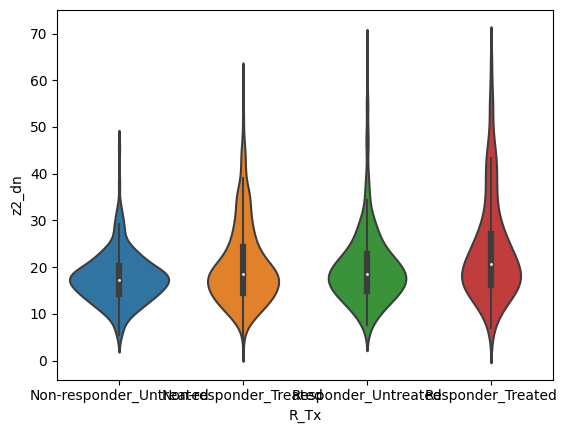

In [41]:
sig = 'z2_dn'
df['R_Tx'] = df['responder'].astype('str') + '_' + df['treated'].astype('str')
order = ['Non-responder_Untreated','Non-responder_Treated',
         'Responder_Untreated','Responder_Treated']
sns.violinplot(df, x='R_Tx', y=sig, order=order)

In [42]:
df.to_csv('sigs_scores_subsampled_tcells_032025.csv')

In [43]:
df.head()

orig.ident  nCount_RNA  \
index                                                                       
GGTGTTAGTTAAGAAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01_on      4361.0   
CGCTATCGTAATAGCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01_on      4142.0   
CCAGCGACAATGACCT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01_on      3981.0   
CATCAGAGTCAAAGAT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01_on      3751.0   
AACTGGTAGCGTTTAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01_on      3610.0   

                                                    nFeature_RNA  percent.mt  \
index                                                                          
GGTGTTAGTTAAGAAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...          2545    2.843385   
CGCTATCGTAATAGCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...          2419    4.345727   
CCAGCGACAATGACCT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...          2203    2.461693   
CATCAGAGTCAAAGAT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...          2186    3.465742   
AACTGGTAGCGTTTAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...          2107    6.980609   

                                                    percent.rps  percent.rpl  \
index                                                                          
GGTGTTAGTTAAGAAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     0.550332     0.871360   
CGCTATCGTAATAGCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     0.410430     0.169000   
CCAGCGACAATGACCT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     0.401909     0.351670   
CATCAGAGTCAAAGAT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     0.186617     0.239936   
AACTGGTAGCGTTTAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     1.329640     2.049861   

                                                    percent.rp  sample  \
index                                                                    
GGTGTTAGTTAAGAAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...    1.421692  F01_on   
CGCTATCGTAATAGCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...    0.579430  F01_on   
CCAGCGACAATGACCT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...    0.753580  F01_on   
CATCAGAGTCAAAGAT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...    0.426553  F01_on   
AACTGGTAGCGTTTAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...    3.379501  F01_on   

                                                   patient condition  ...  \
index                                                                 ...   
GGTGTTAGTTAAGAAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01        on  ...   
CGCTATCGTAATAGCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01        on  ...   
CCAGCGACAATGACCT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01        on  ...   
CATCAGAGTCAAAGAT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01        on  ...   
AACTGGTAGCGTTTAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...     F01        on  ...   

                                                        z6_dn      z7_up  \
index                                                                      
GGTGTTAGTTAAGAAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  15.503972  42.386528   
CGCTATCGTAATAGCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  12.207645  35.538517   
CCAGCGACAATGACCT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  17.555103  40.193226   
CATCAGAGTCAAAGAT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  23.357471  19.032129   
AACTGGTAGCGTTTAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  11.558317  30.629572   

                                                        z7_dn      z8_up  \
index                                                                      
GGTGTTAGTTAAGAAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  22.090034  27.336884   
CGCTATCGTAATAGCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  18.692488  19.390360   
CCAGCGACAATGACCT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  23.690742  28.023281   
CATCAGAGTCAAAGAT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  30.781139  38.065300   
AACTGGTAGCGTTTAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  29.503204  37.259697   

                                                        z8_dn      z9_up  \
index                                                                      
GGTGTTAGTTAAGAAC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...  44.587250  22.229704   
CGCTATCGTAATAGCA-1_1_1_1_1_1_1_1_1_1

### permutation tests

See permutation test code at the beginning of the notebook

In [46]:
# first test R pre vs NR pre for each signature
res_1 = permutation_test_signed(df[df['treated']=='Untreated'][sigs_df.columns], df[df['treated']=='Untreated']['responder'], label_0='Non-responder', label_1='Responder',num_permutations=10000)

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1405.74it/s]


In [47]:
res_1#[res_1['p_value']<0.10]

test_statistic  p_value
z1_up        -3.523130   0.0001
z1_dn         4.703524   0.0000
z2_up         0.919605   0.1739
z2_dn         2.289591   0.0005
z3_up         5.510645   0.0000
z3_dn        -9.072069   0.0000
z4_up         7.401697   0.0000
z4_dn        -6.585951   0.0000
z5_up        -3.176720   0.0021
z5_dn         2.434582   0.0085
z6_up        -1.549568   0.0572
z6_dn         3.924576   0.0000
z7_up        -7.619720   0.0000
z7_dn         5.796896   0.0000
z8_up         5.650541   0.0000
z8_dn        -6.911516   0.0000
z9_up         5.121746   0.0000
z9_dn        -3.857477   0.0002
z10_up        7.278028   0.0000
z10_dn      -10.285586   0.0000

In [48]:
# second test R post vs R pre
res_2 = permutation_test_signed(df[df['responder']=='Responder'][sigs_df.columns], df[df['responder']=='Responder']['treated'], label_0='Untreated', label_1='Treated',num_permutations=10000)

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1417.18it/s]


In [49]:
res_2#[res_2['p_value']<0.10]

test_statistic  p_value
z1_up         1.536926   0.0443
z1_dn        -1.222252   0.0427
z2_up         1.285341   0.0760
z2_dn         3.770157   0.0000
z3_up        12.883051   0.0000
z3_dn        -6.619914   0.0000
z4_up        -6.174814   0.0000
z4_dn         2.567483   0.0000
z5_up         8.681883   0.0000
z5_dn        -7.968067   0.0000
z6_up        -7.850851   0.0000
z6_dn         9.085608   0.0000
z7_up        -6.182405   0.0000
z7_dn        11.653061   0.0000
z8_up        12.708204   0.0000
z8_dn        -5.031087   0.0000
z9_up        12.649237   0.0000
z9_dn        -7.275234   0.0000
z10_up        8.123466   0.0000
z10_dn       -3.923189   0.0000

In [50]:
# third test NR post vs NR pre
res_3 = permutation_test_signed(df[df['responder']=='Non-responder'][sigs_df.columns], df[df['responder']=='Non-responder']['treated'], label_0='Untreated', label_1='Treated',num_permutations=10000)

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1228.12it/s]


In [51]:
res_3#[res_3['p_value']<0.10]

test_statistic  p_value
z1_up         2.096380   0.0024
z1_dn         0.691534   0.1642
z2_up         5.955261   0.0000
z2_dn         2.749977   0.0000
z3_up        13.447910   0.0000
z3_dn       -11.889038   0.0000
z4_up         3.309471   0.0000
z4_dn        -3.983812   0.0000
z5_up         0.195318   0.8367
z5_dn         0.744999   0.4071
z6_up        -7.104624   0.0000
z6_dn        11.693174   0.0000
z7_up        -9.503718   0.0000
z7_dn        10.900743   0.0000
z8_up        10.089245   0.0000
z8_dn        -7.646988   0.0000
z9_up         9.938169   0.0000
z9_dn        -6.002275   0.0000
z10_up       11.105326   0.0000
z10_dn      -10.011504   0.0000

## heatmap to summarize

In [52]:
dfs = {'R_pre_v_NR_pre': res_1, 'R_post_v_R_pre': res_2, 'NR_post_v_NR_pre': res_3}
renamed_dfs = []
for name, df in dfs.items():
    renamed_dfs.append(df.rename(columns=lambda col: f"{name}_{col}"))
df = pd.concat(renamed_dfs, axis=1)
df

R_pre_v_NR_pre_test_statistic  R_pre_v_NR_pre_p_value  \
z1_up                       -3.523130                  0.0001   
z1_dn                        4.703524                  0.0000   
z2_up                        0.919605                  0.1739   
z2_dn                        2.289591                  0.0005   
z3_up                        5.510645                  0.0000   
z3_dn                       -9.072069                  0.0000   
z4_up                        7.401697                  0.0000   
z4_dn                       -6.585951                  0.0000   
z5_up                       -3.176720                  0.0021   
z5_dn                        2.434582                  0.0085   
z6_up                       -1.549568                  0.0572   
z6_dn                        3.924576                  0.0000   
z7_up                       -7.619720                  0.0000   
z7_dn                        5.796896                  0.0000   
z8_up                        5.650541                  0.0000   
z8_dn                       -6.911516                  0.0000   
z9_up                        5.121746                  0.0000   
z9_dn                       -3.857477                  0.0002   
z10_up                       7.278028                  0.0000   
z10_dn                     -10.285586                  0.0000   

        R_post_v_R_pre_test_statistic  R_post_v_R_pre_p_value  \
z1_up                        1.536926                  0.0443   
z1_dn                       -1.222252                  0.0427   
z2_up                        1.285341                  0.0760   
z2_dn                        3.770157                  0.0000   
z3_up                       12.883051                  0.0000   
z3_dn                       -6.619914                  0.0000   
z4_up                       -6.174814                  0.0000   
z4_dn                        2.567483                  0.0000   
z5_up                        8.681883                  0.0000   
z5_dn                       -7.968067                  0.0000   
z6_up                       -7.850851                  0.0000   
z6_dn                        9.085608                  0.0000   
z7_up                       -6.182405                  0.0000   
z7_dn                       11.653061                  0.0000   
z8_up                       12.708204                  0.0000   
z8_dn                       -5.031087                  0.0000   
z9_up                       12.649237                  0.0000   
z9_dn                       -7.275234                  0.0000   
z10_up                       8.123466                  0.0000   
z10_dn                      -3.923189                  0.0000   

        NR_post_v_NR_pre_test_statistic  NR_post_v_NR_pre_p_value  
z1_up                          2.096380                    0.0024  
z1_dn                          0.691534                    0.1642  
z2_up                          5.955261                    0.0000  
z2_dn                          2.749977                    0.0000  
z3_up                         13.447910                    0.0000  
z3_dn                        -11.889038                    0.0000  
z4_up                          3.309471                    0.0000  
z4_dn                         -3.983812                    0.0000  
z5_up                          0.195318                    0.8367  
z5_dn                          0.744999                    0.4071  
z6_up                         -7.104624                    0.0000  
z6_dn                         11.693174                    0.0000  
z7_up                         -9.503718                    0.0000  
z7_dn                         10.900743                    0.0000  
z8_up                         10.089245                    0.0000  
z8_dn                         -7.646988                    0.0000  
z9_up                          9.938169                    0.0000  
z9_dn                         -6.002275             

In [53]:
df.to_csv('tcell_sig_permutation_test_results_032025.csv')

In [54]:
threshold = 0.01
df_heatmap = pd.DataFrame(index=df.index, columns = ['R_pre_v_NR_pre', 'R_post_v_R_pre', 'NR_post_v_NR_pre'])
df_heatmap['R_pre_v_NR_pre'] = (df['R_pre_v_NR_pre_p_value'] < threshold ).astype('float64')
df_heatmap['R_pre_v_NR_pre'] = df_heatmap['R_pre_v_NR_pre'] * df['R_pre_v_NR_pre_test_statistic']
df_heatmap['R_post_v_R_pre'] = (df['R_post_v_R_pre_p_value'] < threshold ).astype('float64')
df_heatmap['R_post_v_R_pre'] = df_heatmap['R_post_v_R_pre'] * df['R_post_v_R_pre_test_statistic']
df_heatmap['NR_post_v_NR_pre'] = (df['NR_post_v_NR_pre_p_value'] < threshold ).astype('float64')
df_heatmap['NR_post_v_NR_pre'] = df_heatmap['NR_post_v_NR_pre'] * df['NR_post_v_NR_pre_test_statistic']
df_heatmap = df_heatmap.astype('float64').T

-9.529107666015625
12.65218505859375


<Axes: >

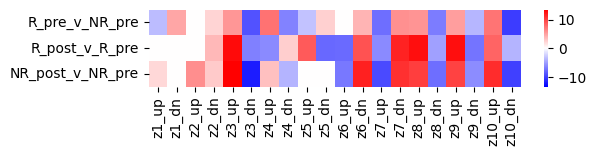

In [55]:
plt.figure(figsize=(6,1))
print(np.quantile(df_heatmap, .05))
print(np.quantile(df_heatmap, .95))
limit = max(np.max(df_heatmap), -np.min(df_heatmap))
sns.heatmap(df_heatmap, cmap='bwr', vmin=-limit, vmax=limit)